<a href="https://colab.research.google.com/github/Marcollins2/MachineLearning/blob/main/Microexpression_Detection_Grp_7E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Resizing
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature



In [ ]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
train_directory = "/content/gdrive/MyDrive/MEs/Train"
validation_directory = "/content/gdrive/MyDrive/MEs/Test"
CLASS_NAMES = ["anger", "happiness", "sadness"]

CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
}

In [ ]:
#
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,
)

Found 600 files belonging to 3 classes.


In [ ]:
#
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,
)


Found 300 files belonging to 3 classes.


In [ ]:
for i in validation_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[172.      , 140.      , 117.      ],
         [172.      , 140.      , 117.      ],
         [166.9375  , 134.9375  , 111.9375  ],
         ...,
         [149.59375 , 108.59375 ,  76.59375 ],
         [142.      , 101.      ,  69.      ],
         [142.      , 101.      ,  69.      ]],

        [[172.      , 140.      , 117.      ],
         [172.      , 140.      , 117.      ],
         [166.9375  , 134.9375  , 111.9375  ],
         ...,
         [149.59375 , 108.59375 ,  76.59375 ],
         [142.      , 101.      ,  69.      ],
         [142.      , 101.      ,  69.      ]],

        [[159.90625 , 127.90625 , 104.90625 ],
         [159.90625 , 127.90625 , 104.90625 ],
         [156.90039 , 124.90039 , 101.90039 ],
         ...,
         [154.03223 , 112.87402 ,  80.87402 ],
         [147.625   , 106.625   ,  74.625   ],
         [147.625   , 106.625   ,  74.625   ]],

        ...,

        [[225.      , 203.      

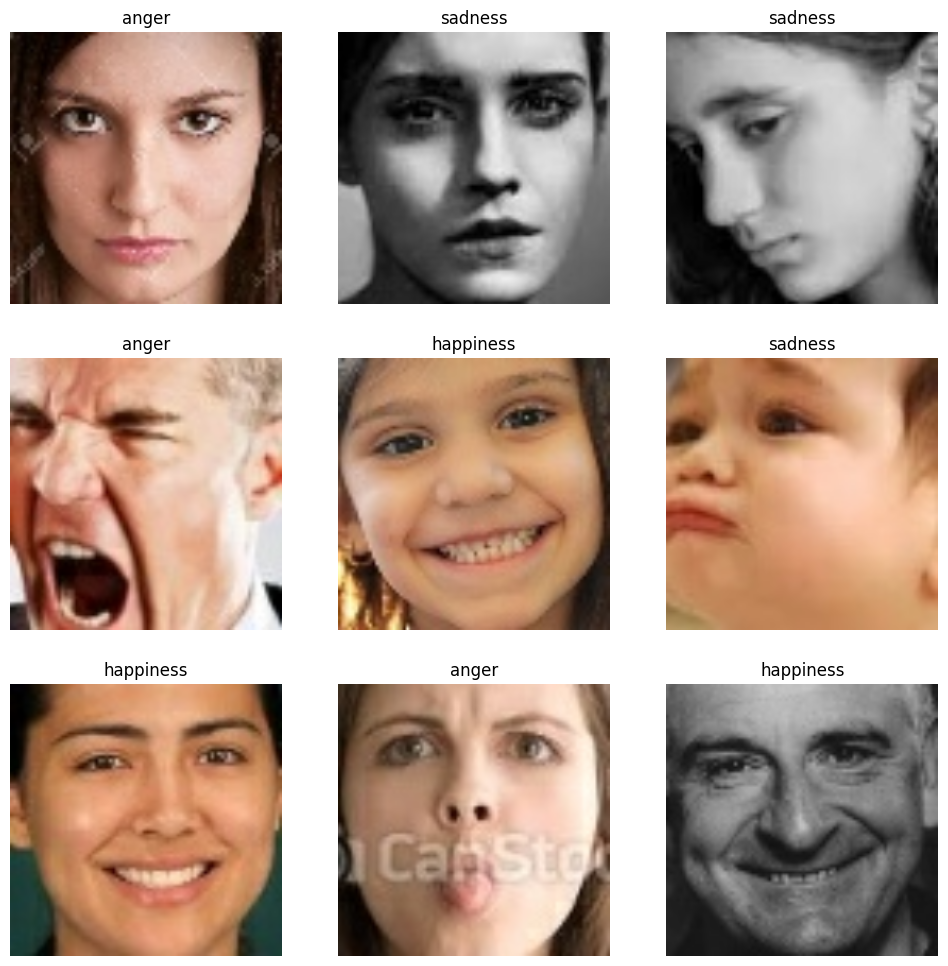

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0). numpy()])
    plt.axis("off")



In [ ]:
training_dataset ={
    train_dataset
    .prefetch(tf.data.AUTOTUNE)

}


In [ ]:
validation_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)



In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    Rescaling (1./255),

])

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)     

Training

In [ ]:
loss_function = CategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [ ]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics)


In [ ]:
history = lenet_model.fit(
  train_dataset,
  validation_data = validation_dataset,
epochs = CONFIGURATION["N_EPOCHS"],
verbose = 1,

)

Epoch 1/20
19/19 [==============================] - 78s 4s/step - loss: 1.0144 - accuracy: 0.4972 - top_k_accuracy: 0.8039 - val_loss: 1.2433 - val_accuracy: 0.3333 - val_top_k_accuracy: 0.8033
Epoch 2/20
19/19 [==============================] - 68s 4s/step - loss: 0.5526 - accuracy: 0.7900 - top_k_accuracy: 0.9467 - val_loss: 1.3500 - val_accuracy: 0.3333 - val_top_k_accuracy: 0.6667
Epoch 3/20
19/19 [==============================] - 76s 4s/step - loss: 0.2402 - accuracy: 0.9267 - top_k_accuracy: 0.9967 - val_loss: 1.1888 - val_accuracy: 0.3367 - val_top_k_accuracy: 0.6717
Epoch 4/20
19/19 [==============================] - 75s 4s/step - loss: 0.0949 - accuracy: 0.9817 - top_k_accuracy: 0.9983 - val_loss: 1.3629 - val_accuracy: 0.3350 - val_top_k_accuracy: 0.6667
Epoch 5/20
19/19 [==============================] - 75s 4s/step - loss: 0.0470 - accuracy: 0.9867 - top_k_accuracy: 1.0000 - val_loss: 1.4494 - val_accuracy: 0.3333 - val_top_k_accuracy: 0.6667
Epoch 6/20
19/19 [============

In [ ]:
print(type(train_dataset))
print(type(validation_dataset))


<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'set'>


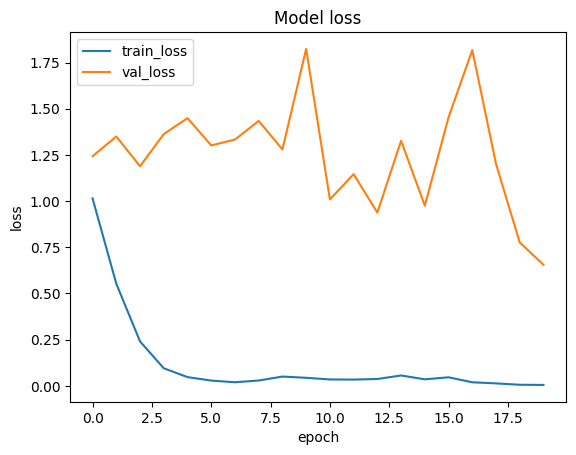

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

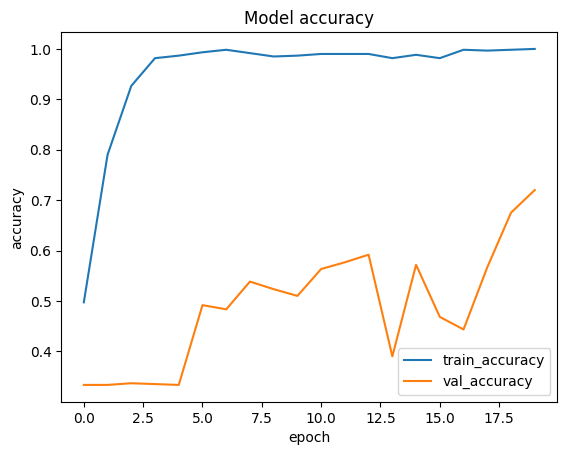

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
lenet_model.evaluate(validation_dataset)

19/19 [==============================] - 16s 791ms/step - loss: 0.6552 - accuracy: 0.7200 - top_k_accuracy: 0.9583


[0.6551839709281921, 0.7200000286102295, 0.9583333134651184]

In [ ]:
test_image = cv2.imread("/content/gdrive/MyDrive/MEs/Test/happiness/happiness10.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)
print(lenet_model(im))

print(CLASS_NAMES[tf.argmax(lenet_model(im), axis = -1).numpy()[0]])


tf.Tensor([[6.8233552e-05 4.6187433e-04 9.9946994e-01]], shape=(1, 3), dtype=float32)
sadness


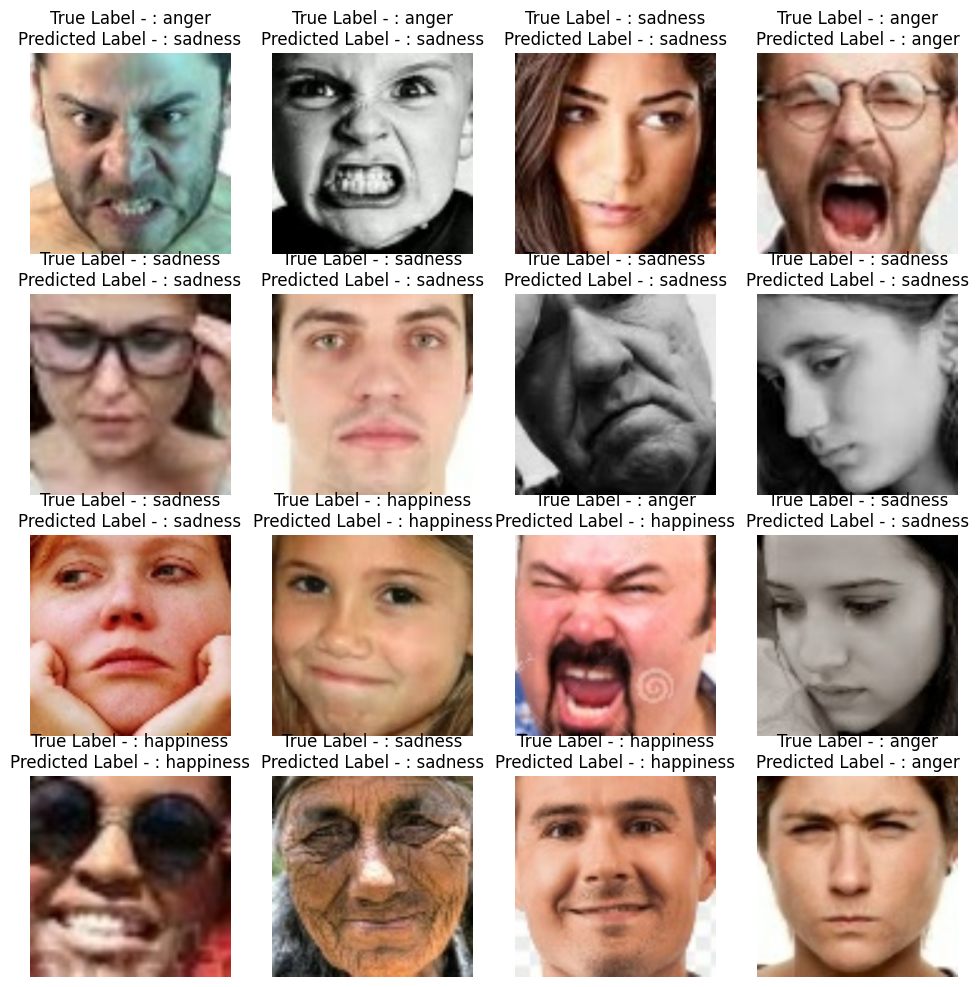

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)

    plt.title("True Label - : " + CLASS_NAMES[tf.argmax(labels[i], axis = -1).numpy()]
              + "\n" + "Predicted Label - : "
              + CLASS_NAMES[int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
    plt.axis("off")

In [ ]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [ ]:
print(labels)

[array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32), array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 

In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[ 87  17  96]
 [  0 145  55]
 [  0   0 200]]


Text(0.5, 58.7222222222222, 'Predicted')

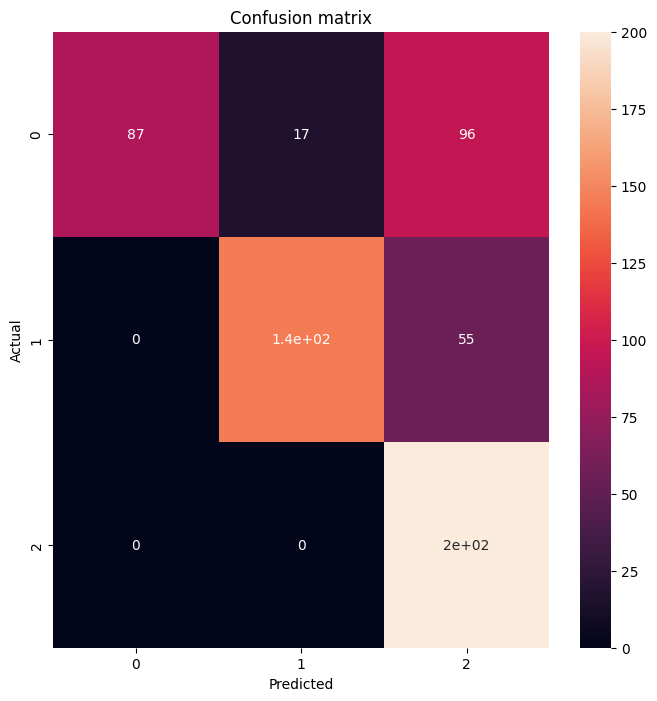

In [ ]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')